In [2]:
import pandas as pd
df = pd.read_csv(r"C:\Users\user\OneDrive\Desktop\newww\BTCUSD-2y.csv")
print(df)

         Date Timestamp     Open     High      Low    Close    Volume
0    20230402  00:00:00  28433.1  28503.4  27843.4  28149.1  0.105614
1    20230403  00:00:00  28149.1  28469.0  27190.2  27768.0  0.579852
2    20230404  00:00:00  27767.9  28402.1  27633.2  28135.8  0.803473
3    20230405  00:00:00  28134.2  28748.1  27776.1  28143.2  1.077828
4    20230406  00:00:00  28142.5  28157.1  27684.7  28007.6  0.283230
..        ...       ...      ...      ...      ...      ...       ...
720  20250328  00:00:00  87174.5  87454.4  83503.7  84316.7  0.436920
721  20250329  00:00:00  84320.9  84519.0  81557.7  82551.7  0.192708
722  20250330  00:00:00  82559.3  83443.8  81538.2  82338.9  0.159753
723  20250331  00:00:00  82352.4  83899.9  81260.5  82518.0  0.237001
724  20250401  00:00:00  82516.9  85496.4  82388.9  85152.6  0.205276

[725 rows x 7 columns]


In [3]:
import numpy as np
from pyts.approximation import SymbolicAggregateApproximation

In [4]:
print("NumPy version:", np.__version__)

sax = SymbolicAggregateApproximation(n_bins=5)
print("pyts is working!")

NumPy version: 1.26.0
pyts is working!


In [5]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

In [6]:
close_prices = df['Close'].values.reshape(1,-1)

Guidelines for Selection:
Small (n_bins = 3 to 5) → Good for noisy data, keeps symbolic representation simple.
Medium (n_bins = 6 to 10) → Balances complexity and granularity.
Large (n_bins = 11+) → More details but can lead to overfitting.


Guidelines for Selection:
Short window (5-20 days) → Captures local patterns but may be too sensitive to noise.
Medium window (20-50 days) → A balance between short-term and long-term trends.
Long window (50+ days) → Captures large trends but may lose short-term variations.

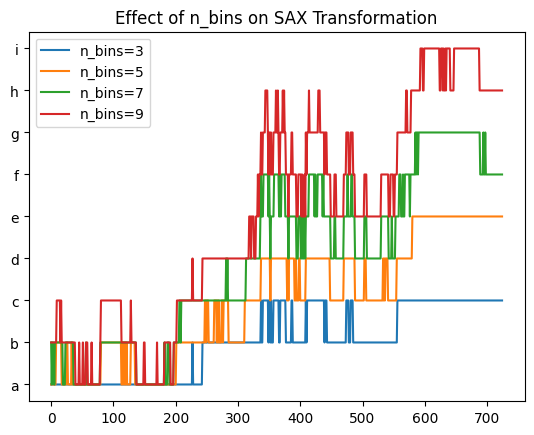

In [7]:
import matplotlib.pyplot as plt
from pyts.approximation import SymbolicAggregateApproximation

# Sample Close prices
close_prices = df['Close'].values.reshape(1, -1)

# Try different n_bins values
for n in [3, 5, 7, 9]:
    sax = SymbolicAggregateApproximation(n_bins=n)
    sax_symbols = sax.fit_transform(close_prices)
    
    plt.plot(sax_symbols.flatten(), label=f'n_bins={n}')

plt.legend()
plt.title("Effect of n_bins on SAX Transformation")
plt.show()


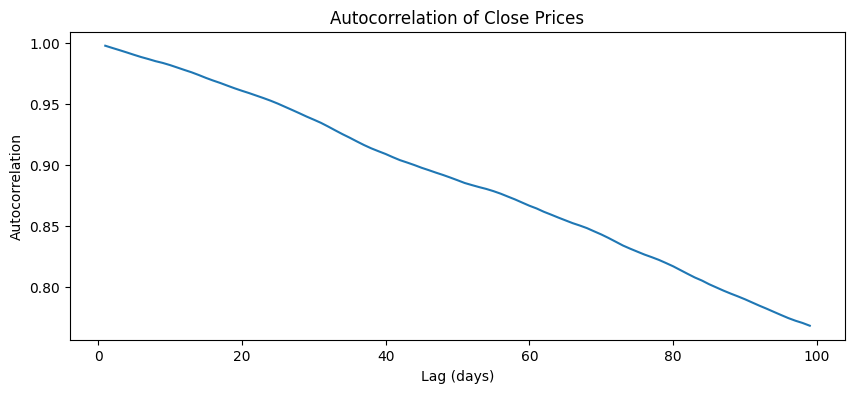

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Compute autocorrelation
autocorr = [df['Close'].autocorr(lag=i) for i in range(1, 100)]

# Plot autocorrelation
plt.figure(figsize=(10, 4))
plt.plot(range(1, 100), autocorr)
plt.xlabel("Lag (days)")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of Close Prices")
plt.show()


If there’s a peak at 30 days, then window_size=30 is a good choice.

If there’s no clear peak, try 20, 50, or 100 and evaluate performance.

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the search space
param_grid = {
    'n_bins': [3, 5, 7, 9],
    'window_size': [10, 30, 50, 100]
}

best_score = -np.inf
best_params = {}

# Try all combinations
for n in param_grid['n_bins']:
    for w in param_grid['window_size']:
        sax = SymbolicAggregateApproximation(n_bins=n)
        sax_symbols = sax.fit_transform(df['Close'].values.reshape(1, -1))
        
        # Train a simple model and get accuracy (Example: Random Forest)
        clf = RandomForestClassifier()
        # Encode symbolic representations into numerical values
        from sklearn.preprocessing import LabelEncoder
        encoder = LabelEncoder()
        encoded_symbols = encoder.fit_transform(sax_symbols.flatten()).reshape(-1, 1)

        # Discretize the target variable into bins
        target_bins = pd.qcut(df['Close'], q=5, labels=False)  # Example: 5 bins
        clf.fit(encoded_symbols, target_bins)
        score = clf.score(encoded_symbols, target_bins)
        
        if score > best_score:
            best_score = score
            best_params = {'n_bins': n, 'window_size': w}

print("Best Parameters:", best_params)


Best Parameters: {'n_bins': 5, 'window_size': 10}


In [10]:
n_bins = 5 #number of discrete symbols
window_size = 10 #define the window size for segmentation

#default are 5 and 30.

In [11]:
sax = SymbolicAggregateApproximation(n_bins=n_bins, strategy='quantile')
sax_symbols = sax.fit_transform(close_prices)

In [12]:
df_sax = pd.DataFrame({'Date': df['Date'], 'SAX': sax_symbols.flatten()})

In [13]:
print(df_sax.head())

        Date SAX
0 2023-04-02   a
1 2023-04-03   a
2 2023-04-04   a
3 2023-04-05   a
4 2023-04-06   a


In [14]:
n_bins = 20
window_size = 5

sax = SymbolicAggregateApproximation(n_bins=n_bins, strategy='quantile')
sax_symbols = sax.fit_transform(close_prices)

df_sax = pd.DataFrame({'Date': df['Date'], 'SAX': sax_symbols.flatten()})

print(df_sax.head())

        Date SAX
0 2023-04-02   d
1 2023-04-03   c
2 2023-04-04   d
3 2023-04-05   d
4 2023-04-06   d


In [15]:
from pyts.approximation import SymbolicAggregateApproximation
import numpy as np
import pandas as pd

# Ensure date is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Define SAX parameters
n_bins = 5  
window_size = 10  # Smaller window to get more symbols

# Initialize SAX transformer
sax = SymbolicAggregateApproximation(n_bins=n_bins)

# Convert Close prices into SAX symbols with a rolling window
sax_symbols = []
for i in range(len(df) - window_size + 1):  # Rolling window
    segment = df['Close'].iloc[i:i + window_size].values.reshape(1, -1)
    symbol = sax.fit_transform(segment)[0, 0]
    sax_symbols.append(symbol)

# Extend to match original DataFrame length
df['SAX'] = ['-'] * (window_size - 1) + sax_symbols  # Fill missing rows with '-'

# Show full results
print(df[['Date', 'SAX']])


          Date SAX
0   2023-04-02   -
1   2023-04-03   -
2   2023-04-04   -
3   2023-04-05   -
4   2023-04-06   -
..         ...  ..
720 2025-03-28   c
721 2025-03-29   b
722 2025-03-30   b
723 2025-03-31   b
724 2025-04-01   c

[725 rows x 2 columns]


In [16]:
df.to_csv('sax_based_data.csv', index=False)

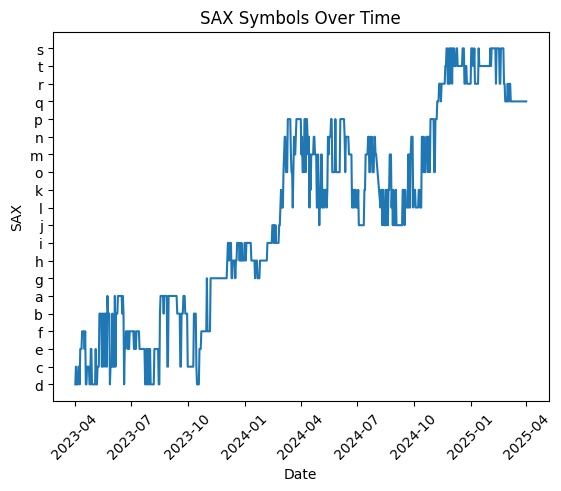

In [20]:
plt.plot(df_sax['Date'], df_sax['SAX'])
plt.xlabel('Date')
plt.ylabel('SAX')
plt.title('SAX Symbols Over Time')
plt.xticks(rotation=45)
plt.show()

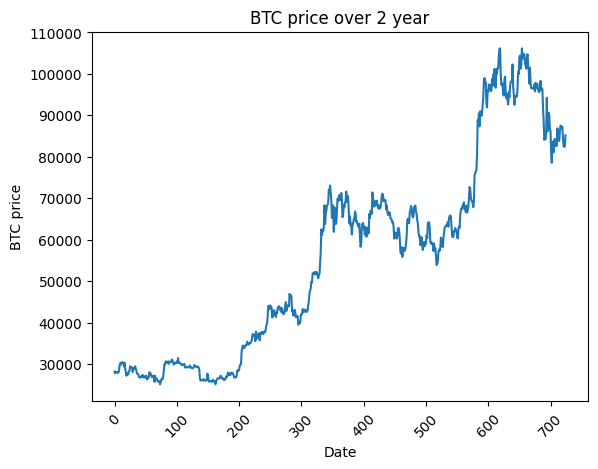

In [24]:
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('BTC price')
plt.title('BTC price over 2 year')
plt.xticks(rotation=45)
plt.show()

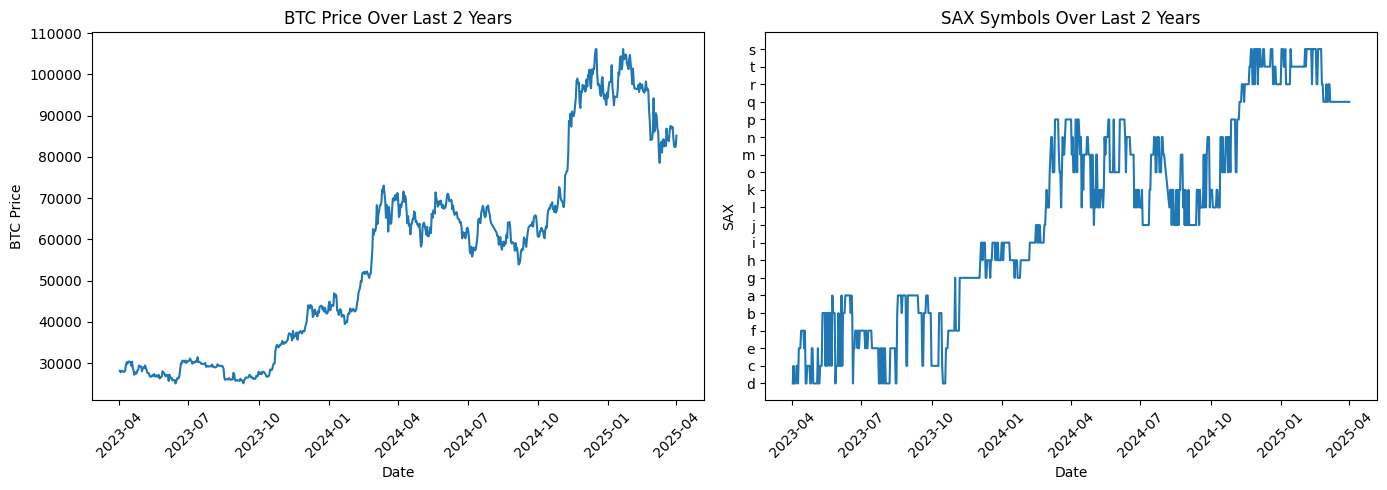

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# First plot: BTC price
axes[0].plot(df['Date'], df['Close'])
axes[0].set_xlabel('Date')
axes[0].set_ylabel('BTC Price')
axes[0].set_title('BTC Price Over Last 2 Years')
axes[0].tick_params(axis='x', rotation=45)

# Second plot: SAX symbols
axes[1].plot(df_sax['Date'], df_sax['SAX'])
axes[1].set_xlabel('Date')
axes[1].set_ylabel('SAX')
axes[1].set_title('SAX Symbols Over Last 2 Years')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout so titles and labels don't overlap
plt.tight_layout()
plt.show()
